In [117]:
import argparse
import cv2, os, glob, math, random, logging
import numpy as np
import matplotlib.pyplot as plt
#import tools as tools

from collections import OrderedDict
from tqdm import tqdm
from copy import deepcopy
from scipy import interpolate

import torch
import torch.nn as nn
from torch.nn import functional as F
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.utils.miscellaneous import mkdir
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
import maskrcnn_benchmark.engine.post_process as util


##################################################################################
############################## functions #########################################
##################################################################################
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
# red, green, blue, yellow, pink, sea, wite, green
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]
def get_color(i):
    m = len(color)
    return color[i] if i < m else color[i%m]

def eliminate_out(sorted_x, sorted_y, confidence = None, image = None):
    out_x = []
    out_y = []

    for lane_x, lane_y in zip(sorted_x, sorted_y):
        
        if len(lane_y) < 3:
            out_x.append(lane_x)
            out_y.append(lane_y)
            continue

        lane_x_along_y = np.array(deepcopy(lane_x))
        lane_y_along_y = np.array(deepcopy(lane_y))

        ind = np.argsort(lane_x_along_y, axis=0)
        lane_x_along_x = np.take_along_axis(lane_x_along_y, ind, axis=0)
        lane_y_along_x = np.take_along_axis(lane_y_along_y, ind, axis=0)
        
        if lane_y_along_x[0] > lane_y_along_x[-1]: #if y of left-end point is higher than right-end
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                               (lane_x_along_x[0], lane_y_along_x[0]), 
                               (lane_x_along_x[1], lane_y_along_x[1]), 
                               (lane_x_along_x[2], lane_y_along_x[2])] # some low y, some left/right x
        else:
            starting_points = [(lane_x_along_y[0], lane_y_along_y[0]), 
                               (lane_x_along_y[1], lane_y_along_y[1]), 
                               (lane_x_along_y[2], lane_y_along_y[2]),
                               (lane_x_along_x[-1], lane_y_along_x[-1]), 
                               (lane_x_along_x[-2], lane_y_along_x[-2]), 
                               (lane_x_along_x[-3], lane_y_along_x[-3])] # some low y, some left/right x            
    
        temp_x = []
        temp_y = []
        for start_point in starting_points:
            temp_lane_x, temp_lane_y = generate_cluster(start_point, lane_x, lane_y, image)
            temp_x.append(temp_lane_x)
            temp_y.append(temp_lane_y)
        
        max_lenght_x = None
        max_lenght_y = None
        max_lenght = 0
        for i, j in zip(temp_x, temp_y):
            if len(i) > max_lenght:
                max_lenght = len(i)
                max_lenght_x = i
                max_lenght_y = j
        out_x.append(max_lenght_x)
        out_y.append(max_lenght_y)

    return out_x, out_y

# image is useless
def generate_cluster(start_point, lane_x, lane_y, image = None):
    cluster_x = [start_point[0]]
    cluster_y = [start_point[1]]

    point = start_point
    while True:
        points = util.get_closest_upper_point(lane_x, lane_y, point, 3)
         
        max_num = -1
        max_point = None

        if len(points) == 0:
            break
        if len(points) < 3:
            for i in points: 
                cluster_x.append(i[0])
                cluster_y.append(i[1])                
            break
        for i in points: 
            num, shortest = util.get_num_along_point(lane_x, lane_y, point, i, image)
            if max_num < num:
                max_num = num
                max_point = i

        total_remain = len(np.array(lane_y)[np.array(lane_y) < point[1]])
        cluster_x.append(max_point[0])
        cluster_y.append(max_point[1])
        point = max_point
        
        if len(points) == 1 or max_num < total_remain/5:
            break

    return cluster_x, cluster_y

### Fit polyline for each line
### Input line should be asc sorted
def fit_polylines_and_resize_backup(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    #xls, yls = merge_point_with_same_y(xls, yls)
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) <=2: # drop 2 points line
            continue
        
        new_line = list()
        y_min, y_max = yl[0], yl[-1]

        num_pts = max( int(abs(y_max - y_min)/3.0), 2 ) 
        ys_sample = np.linspace(y_min, y_max, num=num_pts, endpoint=True)

        #if (y_max - y_min) <= 3.:
        #    ys_sample = np.array([y_min, y_max])
        #else:
        #    ys_sample = np.arange(y_min, y_max, step=3.)

        fitted = np.polyfit(yl, xl, 7)[::-1]
        xs_sample = np.zeros(len(ys_sample))
        for i in range(len(fitted)):
            xs_sample += fitted[i]*ys_sample**i

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)       
    return new_lines

def fit_polylines_and_resize_bkp2(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    #xls, yls = merge_point_with_same_y(xls, yls)
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) < 2: # drop 2 points line
            continue
        xl, yl = merge_point_with_same_y(xl, yl)
        new_line = list()
        y_min, y_max = yl[0], yl[-1]

        num_pts = max( int(abs(y_max - y_min)/3.0), 2 ) 
        ys_sample = np.linspace(y_min, y_max, num=num_pts, endpoint=True)
        '''
        fitted = np.polyfit(yl, xl, 7)[::-1]
        xs_sample = np.zeros(len(ys_sample))
        for i in range(len(fitted)):
            xs_sample += fitted[i]*ys_sample**i
        '''
        k = 3 if len(yl) > 3 else len(yl) - 1
        tck = interpolate.splrep(x=yl, y=xl, s=0, k=k)
        xs_sample = interpolate.splev(x=ys_sample, tck=tck, der=0)

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)       
    return new_lines

def fit_polylines_and_resize(lines, rx, ry):
    xls = [[pt[0] for pt in line] for line in lines]
    yls = [[pt[1] for pt in line] for line in lines]
    #xls, yls = merge_point_with_same_y(xls, yls)
    new_lines = list()
    for xl, yl in zip(xls, yls):
        if len(yl) < 2: # drop 2 points line
            continue
        xs_sample, ys_sample = merge_point_with_same_y(xl, yl)

        new_line = [[x*rx, y*ry] for x,y in zip(xs_sample, ys_sample)]
        new_lines.append(new_line)       
    return new_lines

def drop_short_line(lines, thresh=60.):
    outlines = list()
    for l in lines:
        dist = np.sqrt( (l[0][0] - l[-1][0])**2 + (l[0][1] - l[-1][1])**2 )
        if dist > thresh:
            outlines.append(l)
    return outlines

### Create additional points until image edge
### TBD: Should be conditional!!!
def add_pts_to_image_edge(lines):
    input_width = 1280-1
    input_height = 720-1
    interval = 3.2*2.5
    
    new_lines = list()
    for line in lines:
        x_pt_list = [pt[0] for pt in line]
        y_pt_list = [pt[1] for pt in line]

        max_y = y_pt_list[-1] # bottom pt
        if max_y < input_height: # 255
            y1 = y_pt_list[-2]
            y2 = y_pt_list[-1]
            x1 = x_pt_list[-2]
            x2 = x_pt_list[-1]

            # add points from points(max_y) to img bottom
            while max_y < input_height: # 255
                break_mark = False
                y_new = max_y + interval # 3.2(256/80)
                x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                if x_new < 0:
                    x_new = 0.1
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                elif x_new > input_width:
                    x_new = input_width
                    y_new = y1 + (y2 - y1) * (x_new - x1) / (x2 - x1)
                    break_mark = True
                if y_new > input_height :
                    y_new = input_height
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                elif y_new < 0:
                    y_new = 0.1
                    x_new = x1 + (x2 - x1) * (y_new - y1) / (y2 - y1)
                    break_mark = True
                # check if x/y is valid
                #if ( x_new > input_width or x_new < 0 or y_new > input_height or y_new < 0):
                #    break
                x_pt_list.append(x_new)
                y_pt_list.append(y_new)
                max_y = y_new
                if break_mark:
                    break
        new_line = [[x,y] for x, y in zip(x_pt_list, y_pt_list)] 
        new_lines.append(new_line)
    return new_lines


##################################################################################
############################## regroup/merge lines ###############################
##################################################################################
### input lines: default format (sorted or un-sorted)
### output lines: defualt format (sorted asc along y)
def merge_lines_by_distance(lines):
    if len(lines) < 2:
        return lines
    lines_with_fit = sort_and_fit_lines(lines)
    groups_by_id = group_lines_by_distance(lines_with_fit, thresh=15)
    outlines = list()
    for group_by_id in groups_by_id:
        outline = list()
        for lid in group_by_id:
            outline.extend( lines_with_fit[lid]["line"] )
        outline = sorted(outline, key=lambda pt: pt[1])
        outlines.append(outline)      
    return outlines

def sort_and_fit_lines_backup(lines):
    outlines = list()
    for l in lines:
        l = sorted(l, key=lambda p: p[1])
        yl = [p[1] for p in l]
        xl = [p[0] for p in l]
        fitted_y = np.polyfit(yl, xl, 5)[::-1]
        fitted_x = np.polyfit(xl, yl, 5)[::-1]
        outlines.append({"line": l, "fitted_y": fitted_y, "fitted_x": fitted_x})
    return outlines


def merge_point_with_same_y(xl, yl):
    new_xl, new_yl = list(), list()
    selected = [False] * len(yl)
    for i in range(len(yl)):
        if selected[i]:
            continue # ignore visited or merged point
        xi_sum = xl[i]
        xi_cnt = 1
        selected[i] = True
        for j in range(i+1, len(yl)):
            if selected[j]: # ignore merged point
                continue
            if yl[j] == yl[i]: # merge this point
                selected[j] = True
                xi_sum += xl[j]
                xi_cnt += 1
        new_yl.append(yl[i])
        new_xl.append(xi_sum / xi_cnt)
    return new_xl, new_yl

def sort_and_fit_lines(lines):
    outlines = list()
    for l in lines:
        l = sorted(l, key=lambda p: p[1])
        yl = [p[1] for p in l]
        xl = [p[0] for p in l]
        xl, yl = merge_point_with_same_y(xl, yl)
        if len(yl) < 2:
            continue
        k = 3 if len(yl) > 3 else len(yl) - 1
        fitted_y = interpolate.splrep(x=yl, y=xl, s=0, k=k)

        '''
        tmp = copy.deepcopy(l)
        tmp = sorted(tmp, key=lambda p: p[0])
        yl = [p[1] for p in tmp]
        xl = [p[0] for p in tmp]
        yl, xl = merge_point_with_same_y(yl, xl)
        if len(xl) < 2:
            continue
        k = 3 if len(xl) > 3 else len(xl) - 1
        fitted_x = interpolate.splrep(x=xl, y=yl, s=0, k=k)
        '''

        outlines.append({"line": l, "fitted_y": fitted_y, "fitted_x": fitted_y})
    return outlines

# for lines close either in x or y axis, merge them into a group
# for line far away, make it outside of this group 
def group_lines_by_distance(lines, thresh=15):
    nlines = len(lines)
    selected = [False] * nlines
    groups = list()
    
    if nlines <= 1:
        for i in range( nlines ):
            groups.append([i])
        return groups

    dmat = np.ones((nlines, nlines)) * 1e6
    uldmat = np.ones((nlines, nlines, 2)) * 1e6
    omat = np.ones((nlines, nlines)) * -1
    for i in range(nlines):
        for j in range(i+1, nlines):
            if i == j:
                continue
            else:
                #print(i,j)
                dist1, (udis1, ldis1), overlap1 = compute_dist_y_with_fit(lines[i], lines[j])
                dmat[i,j], dmat[j,i] = dist1, dist1
                uldmat[i,j,0], uldmat[j,i,0] = udis1, udis1
                uldmat[i,j,1], uldmat[j,i,1] = ldis1, ldis1
                omat[i,j], omat[j,i] = overlap1, overlap1
                
                '''
                dist1, (udis1, ldis1), overlap1 = compute_dist_y_with_fit(lines[i], lines[j])
                dist2, (udis2, ldis2), overlap2 = compute_dist_x_with_fit(lines[i], lines[j])
                if dist1 < dist2:
                    dmat[i,j] = dist1
                    dmat[j,i] = dist1
                    uldmat[i,j,0], uldmat[j,i,0] = udis1, udis1
                    uldmat[i,j,1], uldmat[j,i,1] = ldis1, ldis1
                    omat[i,j], omat[j,i] = overlap1, overlap1
                else:
                    dmat[i,j] = dist2
                    dmat[j,i] = dist2
                    uldmat[i,j,0], uldmat[j,i,0] = udis2, udis2
                    uldmat[i,j,1], uldmat[j,i,1] = ldis2, ldis2
                    omat[i,j], omat[j,i] = overlap2, overlap2
                '''
    ###########################
    last_num = nlines
    while last_num > 0:
        closest_ids = np.argmin(dmat)
        p = int(closest_ids / nlines)
        q = closest_ids % nlines
        if dmat[p,q] > thresh:
            for i in range( nlines ):
                if not selected[i]:
                    groups.append([i])
            return groups
        group = [p, q]
        groups.append(group)
        selected[p] = True
        selected[q] = True
        last_num = len(lines)-2 
        if last_num <= 0:
            break

        sid = 0
        while sid < nlines:
            # search other line
            if selected[sid]:
                sid += 1
                continue
            pass_check = True
            for lid in groups[-1]:
                if (dmat[sid, lid] > thresh) or (uldmat[sid, lid, 0] > thresh/2. 
                                                 and omat[sid, lid] > 0.1):
                # if (dmat[sid, lid] > thresh):
                    pass_check = False
                    break      
            if not pass_check:
                sid += 1
                continue
            groups[-1].append(sid)
            selected[sid] = True
            last_num -= 1
            sid += 1
        # group[-1] done
        for lid in groups[-1]:
            dmat[lid,:] = 1e6
            dmat[:,lid] = 1e6
        # end wihle  
    return groups      

# lwf1 and lwf2: line_with_fit
def compute_dist_x_with_fit_backup(lwf1, lwf2, step=3.0):
    #l1 = sorted(l1, key=lambda p: p[1])
    #l2 = sorted(l2, key=lambda p: p[1])
    l1, l2 = lwf1["line"], lwf2["line"]
    f1, f2 = lwf1["fitted_x"], lwf2["fitted_x"]
    
    l1 = sorted(l1, key=lambda p: p[0])
    l2 = sorted(l2, key=lambda p: p[0])
    
    yl1 = [p[1] for p in l1]
    xl1 = [p[0] for p in l1]
    
    yl2 = [p[1] for p in l2]
    xl2 = [p[0] for p in l2]
    
    ub = max(xl1[0], xl2[0])
    lb = min(xl1[-1], xl2[-1])
    
    if ub >= lb:
        if xl1[-1] <= xl2[0]:
            p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        elif xl2[-1] <= xl1[0]:
            p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist, (-1,-1), -1
        else:
            print("error")
            return 1e6, (-1,-1), -10
    else:
        num_pts = max( int((lb - ub)/step), 2 ) 
        xs_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
        
        ys_sample1 = np.zeros(len(xs_sample))
        for i in range(len(f1)):
            ys_sample1 += f1[i]*xs_sample**i
        ys_sample2 = np.zeros(len(xs_sample))
        for i in range(len(f2)):
            ys_sample2 += f2[i]*xs_sample**i
        
        overlap_rate = max( abs((lb - ub)/(xl1[-1] - xl1[0])), abs((lb - ub)/(xl2[-1] - xl2[0])) )
        dists = np.abs(ys_sample1 - ys_sample2)
        dist_sum = np.sum(dists) / len(xs_sample)
        
        return dist_sum, (dist_sum, dist_sum), overlap_rate

# lwf1 and lwf2: line_with_fit
def compute_dist_y_with_fit_backup(lwf1, lwf2, step=3.0):
    #l1 = sorted(l1, key=lambda p: p[1])
    #l2 = sorted(l2, key=lambda p: p[1])
    l1, l2 = lwf1["line"], lwf2["line"]
    f1, f2 = lwf1["fitted_y"], lwf2["fitted_y"]
    
    yl1 = [p[1] for p in l1]
    xl1 = [p[0] for p in l1]
    
    yl2 = [p[1] for p in l2]
    xl2 = [p[0] for p in l2]
    
    ub = max(yl1[0], yl2[0])
    lb = min(yl1[-1], yl2[-1])
    
    if ub >= lb: # seprated or connected
        #print("seprated or connected line")
        if yl1[-1] <= yl2[0]:
            scale = 1.0
            if yl1[-1] < 214 and yl2[0] < 214:
                scale = 1.8

            p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return dist*scale, (-1,-1), -1
        elif yl2[-1] <= yl1[0]:
            scale = 1.0
            if yl2[-1] < 214 and yl1[0] < 214:
                scale = 1.8

            p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
            dist = np.sqrt(np.sum( (p1 - p2)**2 ))
            return scale*dist, (-1,-1), -1
        else:
            print("error")
            return 1e6, (-1,-1), -10
    else: # overlaped line
        #print("overlaped line")
        #ys_sample = np.arange(ub, lb, step=3.0)
        num_pts = max( int((lb - ub)/step), 2 ) 
        ys_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
        xs_sample1 = np.zeros(len(ys_sample))
        for i in range(len(f1)):
            xs_sample1 += f1[i]*ys_sample**i
        xs_sample2 = np.zeros(len(ys_sample))
        for i in range(len(f2)):
            xs_sample2 += f2[i]*ys_sample**i
        overlap_rate = max( abs((lb - ub)/(yl1[-1] - yl1[0])), abs((lb - ub)/(yl2[-1] - yl2[0])) )
        dists = np.abs(xs_sample1 - xs_sample2)
        dist_sum = np.sum(dists) / len(ys_sample)

        ### upper and lower distance
        u_range = [0., 214.] # 86
        l_range = [214., 255.] # 170
        u_ids = np.logical_and(ys_sample >= u_range[0], ys_sample <= u_range[1])
        l_ids = np.logical_and(ys_sample > l_range[0], ys_sample <= l_range[1]) 
        u_dist, l_dist = -1, -1
        if len(dists[u_ids]) > 0:
            u_dist = np.sum( dists[u_ids] ) / len(dists[u_ids])
        if len(dists[l_ids]) > 0:
            l_dist = np.sum( dists[l_ids] ) / len(dists[l_ids])
        # dist_sum =  max(u_dist,0.) * 2. + max(l_dist,0.) 
        dist_sum =  ( np.sum(dists[u_ids]) * 2. + np.sum(dists[l_ids]) ) / ( len(dists[u_ids]) + len(dists[l_ids]) )

        return dist_sum, (u_dist, l_dist), overlap_rate

def com_std(line):
    xs = np.array([p[0] for p in line])
    ys = np.array([p[1] for p in line])
    return np.std(xs), np.std(ys)

def com_std2(l1, l2):
    yl1 = np.array([p[1] for p in l1])
    xl1 = np.array([p[0] for p in l1])
    yl2 = np.array([p[1] for p in l2])
    xl2 = np.array([p[0] for p in l2])
    ub = max(yl1[0],  yl2[0])
    lb = min(yl1[-1], yl2[-1])

    inds1 = np.logical_and(yl1 >= ub, yl1 <= lb)
    inds2 = np.logical_and(yl2 >= ub, yl2 <= lb)
    
    if len(yl1[inds1]) < 2 or len(yl2[inds2]) < 2:
        return False, False

    y1_std = np.std( yl1[inds1] )
    x1_std = np.std( xl1[inds1] )
    y2_std = np.std( yl2[inds2] )
    x2_std = np.std( xl2[inds2] )

    y1_std = y1_std if y1_std != 0 else 1
    y2_std = y2_std if y2_std != 0 else 1

    check1 = y1_std <= 20. and (x1_std/y1_std) >= 5.
    check2 = y2_std <= 20. and (x2_std/y2_std) >= 5.

    return check1, check2
    
def compute_dist_y_with_fit(lwf1, lwf2, step=3.0):
    l1, l2 = lwf1["line"], lwf2["line"]
    
    #x1_std, y1_std = com_std(l1)
    #x2_std, y2_std = com_std(l2)
    #check1 = y1_std <= 20. and (x1_std/y1_std) >= 5.
    #check2 = y2_std <= 20. and (x2_std/y2_std) >= 5.
    check1, check2 = com_std2(l1, l2)

    if check1 and check2:
        l1 = sorted(l1, key=lambda p: p[0])
        l2 = sorted(l2, key=lambda p: p[0])
        ys1, xs1 = [p[1] for p in l1], [p[0] for p in l1]
        ys2, xs2 = [p[1] for p in l2], [p[0] for p in l2]
        ys1, xs1 = merge_point_with_same_y(ys1, xs1) # use to merge same x
        ys2, xs2 = merge_point_with_same_y(ys2, xs2) # use to merge same x
        if len(xs1) < 2 or len(xs2) < 2:
            ## how to compute dist
            return 1e6, (-1,-1), -10 

        ub = max(xs1[0], xs2[0])
        lb = min(xs1[-1], xs2[-1])

        if ub >= lb: # seprated or connected
            #print("seprated or connected line")
            if xs1[-1] <= xs2[0]:
                scale = 1.0
                #if ys1[-1] < 178 and ys2[0] < 178:
                #    scale = 1.5

                p1, p2 = np.array([ys1[-1], xs1[-1]]), np.array([ys2[0], xs2[0]])
                dist = np.sqrt(np.sum( (p1 - p2)**2 ))
                return dist*scale, (-1,-1), -1
            elif xs2[-1] <= xs1[0]:
                scale = 1.0
                #if ys2[-1] < 178 and ys1[0] < 178:
                #    scale = 1.5

                p1, p2 = np.array([ys2[-1], xs2[-1]]), np.array([ys1[0], xs1[0]])
                dist = np.sqrt(np.sum( (p1 - p2)**2 ))
                return scale*dist, (-1,-1), -1
            else:
                print("error")
                return 1e6, (-1,-1), -10
        else: # overlaped line
            #print("overlaped line")
            #ys_sample = np.arange(ub, lb, step=3.0)
            k1 = 3 if len(xs1) > 3 else len(xs1) - 1
            k2 = 3 if len(xs2) > 3 else len(xs2) - 1
            tck1 = interpolate.splrep(x=xs1, y=ys1, s=0, k=k1)
            tck2 = interpolate.splrep(x=xs2, y=ys2, s=0, k=k2)

            num_pts = max( int((lb - ub)/step), 2 ) 
            xs_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
            ys_sample1 = interpolate.splev(x=xs_sample, tck=tck1, der=0)
            ys_sample2 = interpolate.splev(x=xs_sample, tck=tck2, der=0)

            overlap_rate = max( abs((lb - ub)/(xs1[-1] - xs1[0])), abs((lb - ub)/(xs2[-1] - xs2[0])) )
            dists = np.abs(ys_sample1 - ys_sample2)
            dist_sum = np.sum(dists) / len(xs_sample) * 1.5

            u_range = [0., 178.] # 51.2
            l_range = [178., 255.] # 76.8
            u_ids1 = np.logical_and(ys_sample1 >= u_range[0], ys_sample1 <= u_range[1])
            l_ids1 = np.logical_and(ys_sample1 > l_range[0], ys_sample1 <= l_range[1]) 
            u_ids2 = np.logical_and(ys_sample2 >= u_range[0], ys_sample2 <= u_range[1])
            l_ids2 = np.logical_and(ys_sample2 > l_range[0], ys_sample2 <= l_range[1]) 
            if (len(u_ids1)+len(l_ids1)) >= (len(u_ids2)+len(l_ids2)):
                u_ids, l_ids = u_ids1, l_ids1
            else:
                u_ids, l_ids = u_ids2, l_ids2

            u_dist, l_dist = -1, -1
            if len(dists[u_ids]) > 0:
                u_dist = np.sum( dists[u_ids] ) / len(dists[u_ids])
            if len(dists[l_ids]) > 0:
                l_dist = np.sum( dists[l_ids] ) / len(dists[l_ids])
            # dist_sum =  max(u_dist,0.) * 2. + max(l_dist,0.) 
            dist_sum =  ( np.sum(dists[u_ids]) * 3 + np.sum(dists[l_ids]) ) / ( len(dists[u_ids]) + len(dists[l_ids]) )
            #print(dist_sum)

            return dist_sum, (dist_sum, dist_sum), overlap_rate  

    else:
        f1, f2 = lwf1["fitted_y"], lwf2["fitted_y"]
        yl1 = [p[1] for p in l1]
        xl1 = [p[0] for p in l1]
        
        yl2 = [p[1] for p in l2]
        xl2 = [p[0] for p in l2]
        
        ub = max(yl1[0], yl2[0])
        lb = min(yl1[-1], yl2[-1])
        
        if ub >= lb: # seprated or connected
            #print("seprated or connected line")
            if yl1[-1] <= yl2[0]:
                scale = 1.0
                if yl1[-1] < 214 and yl2[0] < 214:
                    scale = 1.8

                p1, p2 = np.array([xl1[-1], yl1[-1]]), np.array([xl2[0], yl2[0]])
                dist = np.sqrt(np.sum( (p1 - p2)**2 ))
                return dist*scale, (-1,-1), -1
            elif yl2[-1] <= yl1[0]:
                scale = 1.0
                if yl2[-1] < 214 and yl1[0] < 214:
                    scale = 1.8

                p1, p2 = np.array([xl2[-1], yl2[-1]]), np.array([xl1[0], yl1[0]])
                dist = np.sqrt(np.sum( (p1 - p2)**2 ))
                return scale*dist, (-1,-1), -1
            else:
                print("error")
                return 1e6, (-1,-1), -10
        else: # overlaped line
            #print("overlaped line")
            #ys_sample = np.arange(ub, lb, step=3.0)
            num_pts = max( int((lb - ub)/step), 2 ) 
            ys_sample = np.linspace(ub, lb, num=num_pts, endpoint=True)
            '''
            xs_sample1 = np.zeros(len(ys_sample))
            for i in range(len(f1)):
                xs_sample1 += f1[i]*ys_sample**i
            xs_sample2 = np.zeros(len(ys_sample))
            for i in range(len(f2)):
                xs_sample2 += f2[i]*ys_sample**i
            '''
            xs_sample1 = interpolate.splev(x=ys_sample, tck=f1, der=0)
            xs_sample2 = interpolate.splev(x=ys_sample, tck=f2, der=0)

            overlap_rate = max( abs((lb - ub)/(yl1[-1] - yl1[0])), abs((lb - ub)/(yl2[-1] - yl2[0])) )
            dists = np.abs(xs_sample1 - xs_sample2)
            dist_sum = np.sum(dists) / len(ys_sample)

            ### upper and lower distance
            u_range = [0., 178.] # 51.2
            l_range = [178., 255.] # 76.8
            u_ids = np.logical_and(ys_sample >= u_range[0], ys_sample <= u_range[1])
            l_ids = np.logical_and(ys_sample > l_range[0], ys_sample <= l_range[1]) 
            u_dist, l_dist = -1, -1
            if len(dists[u_ids]) > 0:
                u_dist = np.sum( dists[u_ids] ) / len(dists[u_ids])
            if len(dists[l_ids]) > 0:
                l_dist = np.sum( dists[l_ids] ) / len(dists[l_ids])
            # dist_sum =  max(u_dist,0.) * 2. + max(l_dist,0.) 
            dist_sum =  ( np.sum(dists[u_ids]) * 2. + np.sum(dists[l_ids]) ) / ( len(dists[u_ids]) + len(dists[l_ids]) )

            return dist_sum, (u_dist, l_dist), overlap_rate



In [2]:
datas = {}
for i in range(4):
    path = "exp/oct29/inference/aicom_lane_test/oct29_265h_r{}.pth".format(i)
    temp = torch.load(path, map_location=torch.device("cpu"))    
    if i == 0:
        g_test_imgs = temp["test_images"]
    for img_id, pred in temp['predictions'].items():
        datas[img_id] = pred
    

def get_imgs(i):
    img_path = g_test_imgs[i].split('/')[-1]
    return cv2.imread('datasets/lane_detection/test/images/'+img_path)

Exist 4 lines.


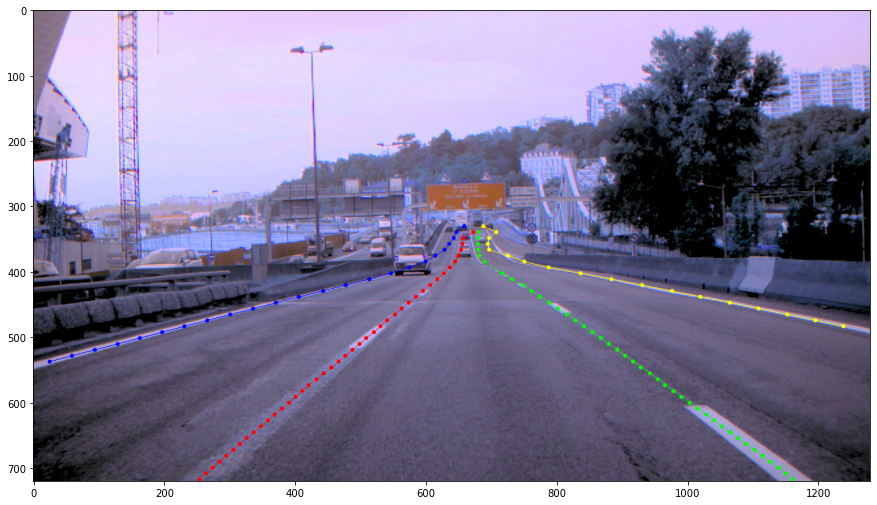

In [120]:
rx, ry = 1280/512., 720/256.
candidates = [43421, 13701, 11864, 17423, 10785, 1360, 163, 2632, 11586, 26175]
img_id= candidates[0] 
prediction = datas[img_id]
    
### 1. In an original group, seprate lines far away into new groups 
outlines = list()
for group in prediction:
    lines_in_group = [it["line"] for it in group]
    probs_in_group = [it["prob"] for it in group]
    ### groups = merge_lines_by_distance(group) ### for previous decoder format
    groups = merge_lines_by_distance(lines_in_group)
    for line in groups:
        outlines.append(line)
    #outlines.append([])
    #for line in lines_in_group:
    #    outlines[-1].extend(line)

### 2. Eliminate outlier

x_lines = [[pt[0] for pt in line] for line in outlines]
y_lines = [[pt[1] for pt in line] for line in outlines]
in_x, in_y = util.sort_along_y(x_lines, y_lines)
in_x, in_y = eliminate_out(in_x, in_y)
in_x, in_y = util.sort_along_y_asc(in_x, in_y)
# in_x, in_y = merge_point_with_same_y(in_x, in_y)
lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]


### 3. Merge close lines either in x-axis or y-axis
regrouped_lines = merge_lines_by_distance(lines)
regrouped_lines = merge_lines_by_distance(regrouped_lines)
regrouped_lines = merge_lines_by_distance(regrouped_lines)

### 4. Fit lines
final_lines = fit_polylines_and_resize(regrouped_lines, rx, ry)


##############################################################
##############################################################
##############################################################
im = get_imgs(img_id) 
for lid, pts in enumerate(final_lines):
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(im, (x1,y1), 3, color[lid], -1)
        cv2.circle(im, (x2,y2), 3, color[lid], -1)
        cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
print("Exist {} lines.".format(len(final_lines)))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

13


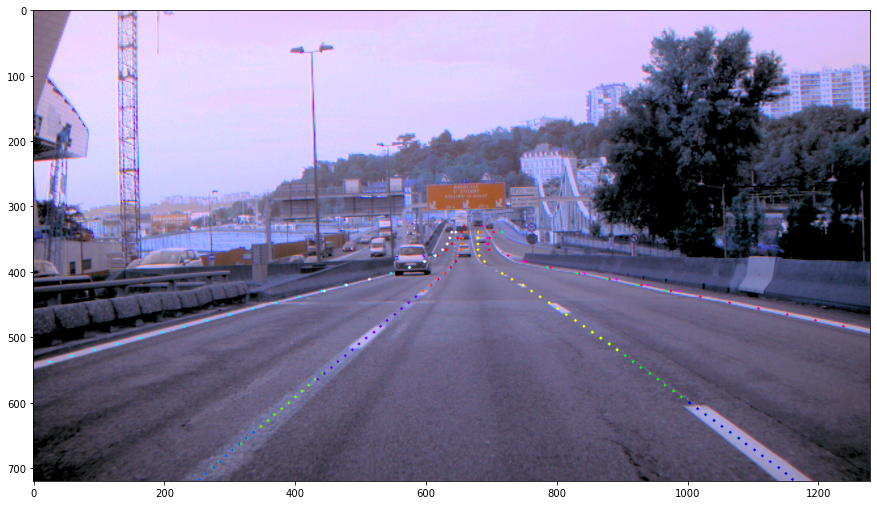

In [122]:
im = get_imgs(img_id)
for lid, l in enumerate(lines):

    for x,y in l:
        x,y = int(x*rx),int(y*ry)
        cv2.circle(im, (x,y), 2, color[lid], -1)
print(len(lines))
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.show() 

In [123]:
candidates=[163, 1151, 1272, 1621, 2091, 2270, 2632, 2842, 3292, 3308, 3504, 3653, 3934, 4058, 4557, 4744, 4939, 5079, 5359, 5459, 5752, 5970, 6518, 6902, 7102, 7948, 8088, 8563, 8911, 9962, 10156, 10718, 11015, 11586, 11793, 12048, 13344, 13913, 14057, 14084, 14492, 14530, 14788, 14837, 14980, 15096, 15257, 15370, 15898, 16086, 16355, 16514, 16621, 16819, 16826, 16840, 17353, 18298, 18513, 18801, 18844, 18953, 19033, 19076, 19686, 20154, 20483, 20644, 20732, 20757, 22052, 22147, 22180, 22282, 22605, 23025, 23238, 23310, 23724, 23787, 23874, 24080, 24151, 24556, 25462, 25551, 26175, 26648, 26748, 27081, 27309, 27658, 27736, 28368, 29836, 30265, 30282, 30365, 30488, 30741, 30816, 31582, 31583, 31597, 32163, 32176, 32558, 32628, 33911, 34345, 34518, 35001, 35305, 35411, 35757, 35990, 36525, 36932, 37086, 37622, 38844, 39004, 39253, 39690, 39969, 40222, 40769, 41525, 41721, 42560, 43457, 43965, 44176, 44306, 44790, 44847, 44906, 44935, 46430, 46512, 46716, 46721, 47028, 47752, 47906, 47921, 48436, 48737, 49037, 49137, 49498, 49611, 50299, 50381, 50611, 50824, 50973, 51401, 51465, 51466, 51552, 51736, 51761, 51844, 51982, 52368, 52645, 52977, 53376, 53427, 53432, 53470, 53500, 53526, 53657, 54011, 54095]

In [124]:
from maskrcnn_benchmark.utils.miscellaneous import mkdir
folder_path = './out_img/test_33'
mkdir(folder_path)

import random
randomlist = []
for i in range(0,100):
    n = random.randint(0,len(datas))
    randomlist.append(n)
    
for img_id in tqdm(candidates):
    prediction = datas[img_id]

    ### 1. In an original group, seprate lines far away into new groups 
    outlines = list()
    for group in prediction:
        lines_in_group = [it["line"] for it in group]
        probs_in_group = [it["prob"] for it in group]
        ### groups = merge_lines_by_distance(group) ### for previous decoder format
        groups = merge_lines_by_distance(lines_in_group)
        for line in groups:
            outlines.append(line)
        #outlines.append([])
        #for line in lines_in_group:
        #    outlines[-1].extend(line)

    ### 2. Eliminate outlier

    x_lines = [[pt[0] for pt in line] for line in outlines]
    y_lines = [[pt[1] for pt in line] for line in outlines]
    in_x, in_y = util.sort_along_y(x_lines, y_lines)
    in_x, in_y = eliminate_out(in_x, in_y)
    in_x, in_y = util.sort_along_y_asc(in_x, in_y)
    # in_x, in_y = merge_point_with_same_y(in_x, in_y)
    lines = [[[x,y] for x,y in zip(xl,yl)] for xl,yl in zip(in_x, in_y)]


    ### 3. Merge close lines either in x-axis or y-axis
    regrouped_lines = merge_lines_by_distance(lines)
    regrouped_lines = merge_lines_by_distance(regrouped_lines)
    regrouped_lines = merge_lines_by_distance(regrouped_lines)

    ### 4. Fit lines
    final_lines = fit_polylines_and_resize(regrouped_lines, rx, ry)


    ##############################################################
    ##############################################################
    ##############################################################
    im = get_imgs(img_id) 
    for lid, pts in enumerate(final_lines):
        for i in range(len(pts)-1):
            x1 = int(pts[i][0])
            y1 = int(pts[i][1])
            x2 = int(pts[i+1][0])
            y2 = int(pts[i+1][1])
            cv2.circle(im, (x1,y1), 3, color[lid], -1)
            cv2.circle(im, (x2,y2), 3, color[lid], -1)
            cv2.line(im, (x1,y1), (x2,y2), color[lid], 1) 
    path = os.path.join(folder_path, 'pred_{}.png'.format(img_id))
    cv2.imwrite(path, im)

100%|██████████| 177/177 [00:34<00:00,  5.09it/s]
